In [1]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import pandas as pd
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [61]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")

In [62]:
model.config.label2id

{'bicycle': 18,
 'building': 2,
 'bus': 15,
 'car': 13,
 'fence': 4,
 'motorcycle': 17,
 'person': 11,
 'pole': 5,
 'rider': 12,
 'road': 0,
 'sidewalk': 1,
 'sky': 10,
 'terrain': 9,
 'traffic light': 6,
 'traffic sign': 7,
 'train': 16,
 'truck': 14,
 'vegetation': 8,
 'wall': 3}

In [3]:
def crop_image(img):
    original_width, original_height = img.size
    
    # Define the amount to crop from each side
    crop_left = 500
    crop_right = 500
    
    # Calculate the new dimensions
    new_width = original_width - (crop_left + crop_right)
    area = (crop_left, 0, original_width - crop_right, original_height)
    return img.crop(area)

In [4]:
#Load Data

# Path to your CSV file and image folder
csv_path = '../data/Annotations.csv'
image_folder = '../data/images/'

# Read the CSV file
df = pd.read_csv(csv_path)

# Lists to hold image arrays and classes
images = []
classes = []

# Load each image and its class
for index, row in df.iterrows():
    if index < 8:
        continue
    # Full path to image
    img_path = image_folder + row['Picture']
    # Open and convert the image to a numpy array
    img = Image.open(img_path)
    area = (100, 100, 300, 300)
    cropped = crop_image(img)
    # Append the image array and class to the lists
    images.append(cropped)
    classes.append(row['Class'])

In [6]:
print(len(images))
print(classes.count(1))
print(classes.count(0))

93
42
51


In [26]:
def predict_picture(image):
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

47.55288912330052


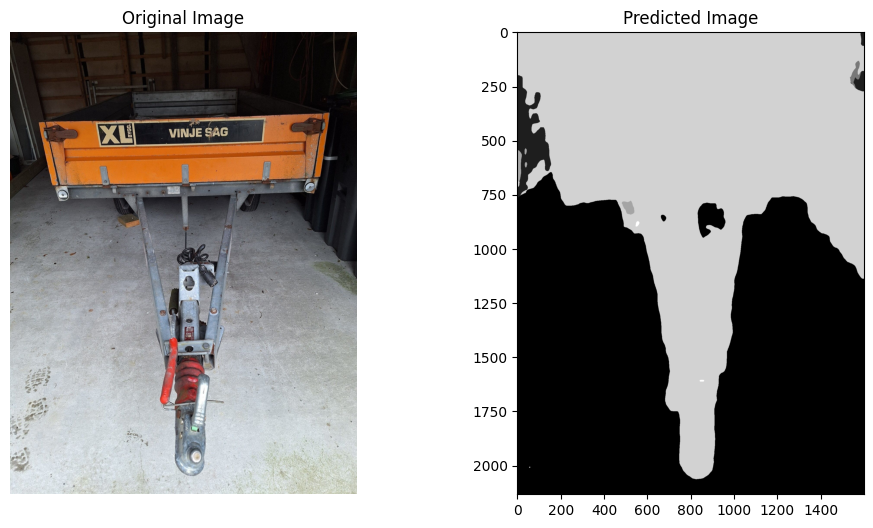

In [59]:
image = Image.open("henger.jpeg").convert('RGB')
predicted = predict_picture(image)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

elements_equal_to_13 = torch.eq(predicted, 14)
count_of_13 = torch.sum(elements_equal_to_13).item()
num_car_pixels = count_of_13
total_number_of_pixels = predicted.numel()
percentage = num_car_pixels * 100 / total_number_of_pixels

print(percentage)
ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')  # Turn off axis labels and ticks

# Display the predicted image
ax2.imshow(predicted, cmap="gray")
ax2.set_title('Predicted Image')
ax2.axis('on')  # Turn off axis labels and ticks

plt.show()

In [58]:
predicted[600][600]

tensor(14)

In [30]:
pixel_percentage_occupied = []
pixel_percentage_unoccupied = []

for i in range(len(images)):
    predicted = predict_picture(images[i])
    elements_equal_to_13 = torch.eq(predicted, 13)
    count_of_13 = torch.sum(elements_equal_to_13).item()
    num_car_pixels = count_of_13; 
    total_number_of_pixels = predicted.numel()
    percentage = num_car_pixels * 100 / total_number_of_pixels; 
    if classes[i] == 0 and percentage > 20:
        pixel_percentage_unoccupied.append((i, percentage))
    elif classes[i] == 1 and percentage < 20:
        pixel_percentage_occupied.append((i, percentage))

In [31]:
pixel_percentage_occupied

[(0, 33.81317745753561),
 (6, 32.079074349017816),
 (7, 39.498142831928234),
 (8, 37.15387370737987),
 (10, 45.374794945803394),
 (11, 39.53772607874081),
 (14, 48.081769903235184),
 (15, 44.687052255077035),
 (17, 52.9070974708252),
 (18, 59.86304196602849),
 (19, 32.043871215582044),
 (21, 66.95772249678143),
 (22, 59.396511223472736),
 (24, 49.618897690934006),
 (25, 62.12960463474397),
 (28, 50.48119601104697),
 (29, 81.28546269570995),
 (32, 56.12631857635284),
 (33, 45.02630014743137),
 (38, 73.63119834710744),
 (40, 0.0),
 (51, 62.83918300178579),
 (55, 23.710721738859586),
 (56, 29.520114778437645),
 (60, 23.99461797624486),
 (63, 25.214560664894723),
 (65, 29.31502813655052),
 (66, 29.140083163752646),
 (69, 20.326289245815857),
 (71, 25.68326524149674),
 (72, 21.93768428921467),
 (74, 23.137024222351428),
 (75, 22.334133217741602),
 (77, 28.359903858133645),
 (81, 2.206895790938162),
 (82, 28.210558214626854),
 (85, 40.840988257402714),
 (87, 31.16324130985506),
 (88, 35.1101

In [32]:
pixel_percentage_unoccupied

[(1, 0.0),
 (2, 0.44557108891565267),
 (3, 0.8380941380455998),
 (4, 0.10327333983969433),
 (5, 7.993479795672577),
 (9, 3.7394487935545495),
 (12, 2.2196792329415675),
 (13, 3.8798395386021016),
 (16, 7.439444121433614),
 (20, 3.773126998629511),
 (23, 8.016970181485942),
 (26, 4.594933603970264),
 (27, 5.0443981269986296),
 (30, 10.069004630590971),
 (31, 2.5298885958719217),
 (34, 3.1617605070808588),
 (35, 0.0),
 (36, 0.0),
 (37, 0.6297305224469455),
 (39, 5.178526932181569),
 (41, 0.0),
 (42, 0.0),
 (43, 5.431145915528053),
 (44, 0.0),
 (45, 0.0),
 (46, 0.0),
 (47, 0.0),
 (48, 0.0),
 (49, 0.0),
 (50, 2.5277147618256572),
 (52, 0.0),
 (53, 2.8901285871506293),
 (54, 7.961034511399975),
 (57, 0.0),
 (58, 0.0),
 (59, 1.0595656484903857),
 (61, 4.319440695211595),
 (62, 0.0),
 (64, 11.390695730719715),
 (67, 6.949293211927405),
 (68, 7.163724095685037),
 (70, 6.26284833257195),
 (73, 4.4294302088957185),
 (76, 5.2046453860210145),
 (78, 0.7762209809377466),
 (79, 2.837242773786287),
 

: 

tensor(14)

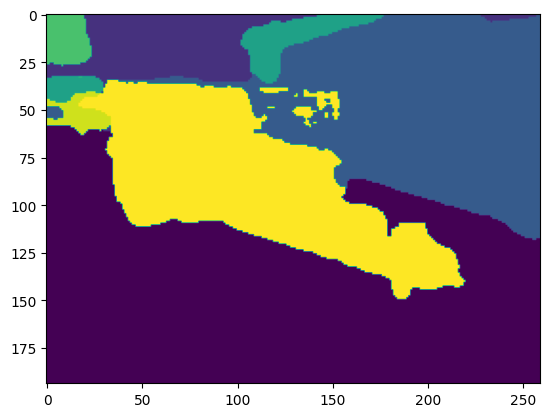

In [154]:
trailer_picture = Image.open("/Users/olelokken/DEV/parking-control-center/slot_vision/data/tilhenger.jpeg")
predicted_trailer = predict_picture(trailer_picture)
plt.imshow(predicted_trailer)
predicted_trailer[100][100]

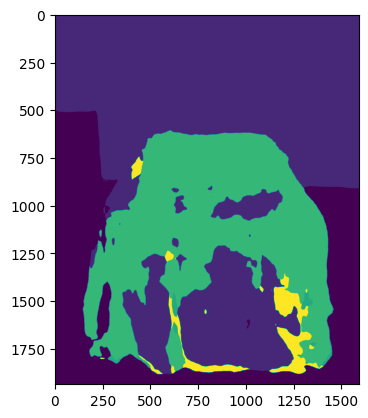

In [156]:
predicted_covered = predict_picture(images[40])
plt.imshow(predicted_covered)

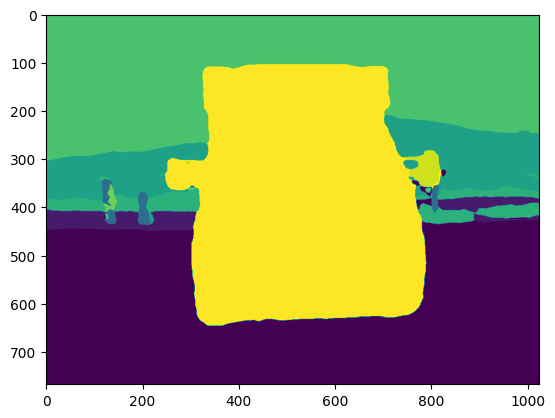

In [10]:
camping_trailer = Image.open("/Users/olelokken/DEV/parking-control-center/slot_vision/camping.jpeg")
predicted_camping = predict_picture(camping_trailer)
plt.imshow(predicted_camping)

In [13]:
predicted_camping[600][500]

tensor(14)